# Collaborative filtering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as scsp

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

# Display
import ipywidgets as w
from ipywidgets import widgets, HBox, VBox
from IPython.core.display import HTML
from movie_display import movie_display

app = w.Output()

## Analyzing the given ratings dataset
Show graphs in which the characteristics of the ratings are shown:
1. Distribution of how often a movie is rated
2. Distribution of how often a specific rating was given
3. Distribution of the average ratings given to a movie
4. Distribution of the average ratings given by the users
5. Something you want to learn from the data set

The following files are going to be used for plotting these graphs:
- Movie info: `movies.csv`
  - `movieId, title, genres`
- Movie ratings by users: `ratings.csv`
  - `userId, movieId, rating, timestamp`

In [2]:
movies = pd.read_csv('./dataset/movies.csv')
ratings = pd.read_csv('./dataset/ratings.csv')
test_ratings = pd.read_csv('./dataset/test.csv')

In [3]:
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [4]:
ratings.head(3)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182


In [5]:
test_ratings

,userId,movieId,rating
0,1,1,4.0
1,1,4,5.0
2,1,5,1.0
3,2,1,5.0
4,2,2,5.0
5,2,3,4.0
6,3,4,2.0
7,3,5,4.0
8,3,6,5.0
9,4,2,3.0


### 1. Distribution of how often a movie is rated

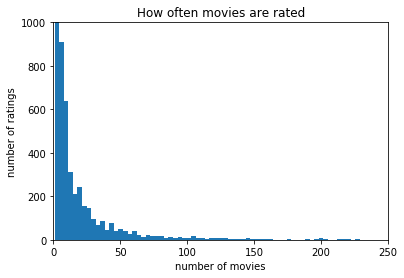

In [6]:
rate_count = ratings[['movieId', 'rating']].groupby('movieId').count()
_ = rate_count.plot.hist(bins=100, title='How often movies are rated', xlim=(0, 250), ylim=(0, 1000), legend=False).set(xlabel='number of movies', ylabel='number of ratings')

### 2. Distribution of how often a specific rating was given

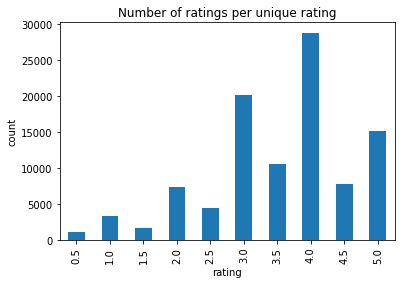

In [7]:
specific_rate_count = ratings[['rating', 'movieId']].groupby('rating').count()
_ = specific_rate_count.plot(kind='bar', title='Number of ratings per unique rating', legend=False).set_ylabel('count')

### 3. Distribution of the average ratings given to a movie

This shows that an average rating for a movie of 3.5 - 4.0 occurs most.

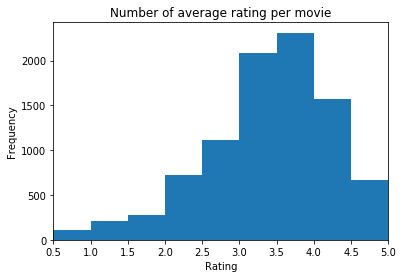

In [8]:
avg_movie_ratings = ratings[['movieId', 'rating']].groupby('movieId').mean()
_ = avg_movie_ratings.plot.hist(bins=9, xlim=(0.5, 5), title='Number of average rating per movie', legend=False).set_xlabel('Rating')

### 4. Distribution of the average ratings given by the users

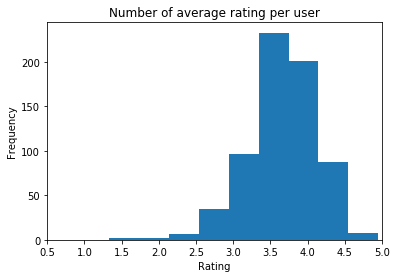

In [9]:
avg_user_ratings = ratings[['userId', 'rating']].groupby('userId').mean()
_ = avg_user_ratings.plot.hist(bins=9, xlim=(0.5, 5), title='Number of average rating per user', legend=False).set_xlabel('Rating')

## User-item matrix

A table with every rating from every user for every movie. We use a sparse matrix, because there will be alot of 'empty' ratings.

```
structure:
   /      movieids
userids   ratings

example:
   /      0,   1,   2
   0      0.5  4.0  0.0
   1      0.0  1.0  2.5
   2      1.5  5.0  3.5
```

In the example above, user 0 rated movie 0 with 0.5 (stars) and user 2 rated movie 1 with 5 (starts).

Because the user and movie ids in the provided data start at 0, the 0th indices are always `0.0`. Therefore: `shape=(row.max() + 1, col.max() + 1)`.

In [10]:
user_item_df = ratings.pivot(index='userId', columns='movieId', values='rating')
user_item_df.head(10)

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
item_user_df = ratings.pivot(index='movieId', columns='userId', values='rating')
item_user_df.head(10)

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,4.0,NaN,...,NaN,4.0,3.5,NaN,NaN,NaN,NaN,NaN,4.0,5.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,5.0,4.0,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## User-user matrix

A table with the similiarity of every user to every user.

Derive user-user similarity matrices based on:

1. Cosine similarity
2. Pearson similarity
3. Adjusted cosine similarity

and give N (configurable) recommendations for a given user U (configurable) derived from the ratings of the 10 most similar users for each of these similarities.

Note:

- Because every user is perfectly similar to themselves, a diagonal line of 'perfect' `1.0` scores occurs from the top left to the bottom right.

### 1. Cosine similarity

Cosine angle distance between items.

In [12]:
cosine_user_user_df = pd.DataFrame(cosine_similarity(user_item_df.fillna(0)), 
                                    index=user_item_df.index, 
                                    columns=user_item_df.index)
cosine_user_user_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.000000,0.000000,0.074482,0.016818,0.000000,0.083884,0.000000,0.012843,0.000000,...,0.000000,0.000000,0.014474,0.043719,0.000000,0.000000,0.000000,0.062917,0.000000,0.017466
2,0.000000,1.000000,0.124295,0.118821,0.103646,0.000000,0.212985,0.113190,0.113333,0.043213,...,0.477306,0.063202,0.077745,0.164162,0.466281,0.425462,0.084646,0.024140,0.170595,0.113175
3,0.000000,0.124295,1.000000,0.081640,0.151531,0.060691,0.154714,0.249781,0.134475,0.114672,...,0.161205,0.064198,0.176134,0.158357,0.177098,0.124562,0.124911,0.080984,0.136606,0.170193
4,0.074482,0.118821,0.081640,1.000000,0.130649,0.079648,0.319745,0.191013,0.030417,0.137186,...,0.114319,0.047228,0.136579,0.254030,0.121905,0.088735,0.068483,0.104309,0.054512,0.211609
5,0.016818,0.103646,0.151531,0.130649,1.000000,0.063796,0.095888,0.165712,0.086616,0.032370,...,0.191029,0.021142,0.146173,0.224245,0.139721,0.058252,0.042926,0.038358,0.062642,0.225086


### 2. Pearson similarity

Cosine angle distance between items.

Values are first centered around zero by subtracting the row average from it.

In [13]:
_c = user_item_df.copy()

centered_user_item_df = _c[_c > 0].subtract(user_item_df.mean(axis=1), axis=0).fillna(0)

centered_user_item_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.513158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,-0.348039,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.09,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
pearson_user_user_df = pd.DataFrame(cosine_similarity(centered_user_item_df.fillna(0)), 
                                    index=user_item_df.index, 
                                    columns=user_item_df.index)
pearson_user_user_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.000000,0.000000,0.003620,-0.002274,0.000000,-0.070321,0.000000,0.042632,0.000000,...,0.000000,0.000000,0.018643,0.001031,0.000000,0.000000,0.000000,0.044095,0.000000,-0.013096
2,0.000000,1.000000,-0.001852,-0.004854,0.012639,0.000000,0.042691,0.021066,0.011109,-0.007989,...,-0.018248,-0.021546,0.018902,-0.058952,0.028515,-0.106828,-0.007999,-0.041628,-0.090233,0.056258
3,0.000000,-0.001852,1.000000,0.018594,-0.025903,-0.063200,0.054900,0.026488,-0.036187,0.038021,...,0.044297,0.019581,0.070702,0.030669,0.143705,0.096713,0.027451,0.089297,-0.009815,0.062276
4,0.003620,-0.004854,0.018594,1.000000,0.010801,0.019224,0.057519,0.055430,-0.010442,0.005126,...,0.011978,0.006569,0.027687,0.092092,0.021334,0.040833,0.018428,0.028642,0.019848,0.032749
5,-0.002274,0.012639,-0.025903,0.010801,1.000000,-0.005843,-0.015075,-0.038886,0.013708,0.030500,...,0.046134,0.001903,0.001620,0.036819,-0.038269,-0.019537,-0.071721,0.003760,-0.029455,-0.036814


### 3. Adjusted cosine similarity

In [15]:
_c = user_item_df.copy()

centered_item_user_df = _c[_c > 0].subtract(user_item_df.mean(axis=0), axis=1).fillna(0)

centered_item_user_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.54918,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.54918,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.838983,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
adj_cosine_user_user_df = pd.DataFrame(cosine_similarity(centered_item_user_df.fillna(0)), 
                                    index=user_item_df.index, 
                                    columns=user_item_df.index)
adj_cosine_user_user_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.000000,0.000000,-0.042928,-0.020326,0.000000,-0.084835,0.000000,0.056693,0.000000,...,0.000000,0.000000,0.001404,0.002595,0.000000,0.000000,0.000000,0.000023,0.000000,0.021158
2,0.000000,1.000000,0.026386,-0.018799,0.014673,0.000000,0.040012,-0.022239,0.001264,-0.023076,...,-0.011616,0.006937,0.002182,-0.062952,-0.079717,-0.147949,-0.042216,-0.011552,-0.115512,0.042947
3,0.000000,0.026386,1.000000,-0.017612,-0.030283,-0.040315,-0.028884,-0.029348,-0.054177,-0.006088,...,-0.055113,0.007258,-0.011623,-0.032968,0.194814,0.046531,-0.057462,0.103936,-0.040322,-0.001326
4,-0.042928,-0.018799,-0.017612,1.000000,0.023250,0.008572,-0.046809,0.004820,-0.012379,-0.031362,...,-0.024827,-0.007848,0.022981,0.028751,-0.034598,0.005869,-0.000343,-0.010801,0.011823,0.027860
5,-0.020326,0.014673,-0.030283,0.023250,1.000000,0.010561,-0.021507,-0.011979,-0.006786,0.038089,...,0.025104,0.000131,0.049178,0.065194,-0.051955,-0.022723,-0.058358,0.037019,0.001900,-0.017869


## Recommend Movies Using Similiar Users

`matrix[user]` gives the similiarities

In [17]:
def get_similiar_users(user_user_df, user_id, n_users=10):
    """
    Get the n_users most similiar users according to the provided user-user-matrix.
    Returned list includes the user_id provided.
    
    User ids start at 1 and in the below dataframe at 0. This is corrected before returning the list.
    """
    return user_user_df.loc[user_id].sort_values(ascending=False).index[:n_users+1]

def recommend_movies(user_item_df, user_ids, n_movies=10):
    """
    
    """
    user_id = user_ids[0]
    similiar_user_ids = user_ids[1:]
    similiar_df = user_item_df.loc[user_ids]
    movie_ids = set()
    # Add the movies other similiar users have seen to the set
    for u_id in similiar_user_ids:
        movie = similiar_df.loc[u_id][similiar_df.loc[u_id].notna()]
        movie_ids.update(zip(movie.index, movie.values))
    # Remove the movies the user has already seen from the set
    user_movies = similiar_df.loc[user_id][similiar_df.loc[user_id].notna()]
    for t in zip(user_movies.index, user_movies.values):
        movie_ids.discard(t)
    # Sort the movie tuples on their rankings so we recommend the movies that other similiar users have rated highest
    return sorted(list(movie_ids), key=lambda x: x[1], reverse=True)[:n_movies]

def recommend(user_user_df, user_item_df, user_id, n_users=10, n_movies=10):
    su = get_similiar_users(user_user_df, user_id, n_users)
    rm = recommend_movies(user_item_df, su, n_movies)
    return movies[movies.movieId.isin([m[0] for m in rm])]


In [18]:
similiar_users = get_similiar_users(user_user_df=pearson_user_user_df, user_id=5)
similiar_users

Int64Index([5, 395, 75, 365, 645, 127, 182, 375, 398, 174, 108], dtype='int64', name='userId')

In [19]:
recommended_movies = recommend_movies(user_item_df=user_item_df, user_ids=similiar_users)
recommended_movies

[(8, 5.0),
 (454, 5.0),
 (802, 5.0),
 (237, 5.0),
 (587, 5.0),
 (1049, 5.0),
 (780, 5.0),
 (2916, 5.0),
 (5991, 5.0),
 (500, 5.0)]

In [20]:
recommend(user_user_df=pearson_user_user_df, user_item_df=user_item_df, user_id=8)

,movieId,title,genres
9,10,GoldenEye (1995),Action|Adventure|Thriller
525,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
960,1203,12 Angry Men (1957),Drama
964,1208,Apocalypse Now (1979),Action|Drama|War
969,1213,Goodfellas (1990),Crime|Drama
1870,2360,"Celebration, The (Festen) (1998)",Drama
4259,5669,Bowling for Columbine (2002),Documentary
5021,7147,Big Fish (2003),Drama|Fantasy|Romance
5480,8622,Fahrenheit 9/11 (2004),Documentary
6966,59784,Kung Fu Panda (2008),Action|Animation|Children|Comedy|IMAX


## Item-item collaborative filtering

1. Take the K highest rated items of a user
2. Find L similar items
  - This is a pre-selection of movies that will probably have high predicted ratings. We don't want to recommend low predicted ratings anyway.
3. For each similar item that has not been seen by the user, calculate the expected rating (Weighted arithmetic mean)
4. Select the top N movies with the highest rating

Note: let L be much larger than N.

In [21]:
_c = item_user_df.copy()
centered_item_item_df = _c[_c > 0].subtract(item_user_df.mean(axis=1), axis=0)
pearson_item_item_df = pd.DataFrame(cosine_similarity(centered_item_item_df.fillna(0)), 
                                    index=item_user_df.index, 
                                    columns=item_user_df.index)
pearson_item_item_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.143077,0.076882,0.008127,0.093661,0.014571,0.109841,0.005078,-0.059312,0.029760,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.143077,1.000000,0.023050,0.042711,0.009544,-0.003685,0.103450,0.123319,0.052530,0.193042,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.076882,0.023050,1.000000,0.015516,0.227926,-0.000419,0.022623,0.139844,0.102854,0.023421,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.008127,0.042711,0.015516,1.000000,0.091506,-0.020982,0.185295,0.149702,-0.072775,0.033461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.093661,0.009544,0.227926,0.091506,1.000000,0.114900,0.005068,0.127919,0.088390,0.013011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
def predict_rating(user_id, movie_id, user_item_df, item_item_df, sample_size=20, rating_threshold=0.0):
    # All movies similiar to the unrated movie
    similiarities_unrated_movie = item_item_df.loc[movie_id]

    # Rated movies by the user most similiar to the unrated movie HIGHER THAN OR EQUAL TO rating_threshold
    ratings = user_item_df.loc[user_id]
    sims = similiarities_unrated_movie[ratings[ratings >= rating_threshold].index]\
                                      .sort_values(ascending=False)[1:sample_size+1]
    # Average of the user ratings weighted by the similiarities to the unrated movie
    divider = sims.sum() if sims.sum() > 0.0 else len(sims)
    weights = sims if sims.sum() > 0.0 else 1.0
    return (user_item_df.loc[user_id, sims.index] * weights).sum() / divider

def recommend_item_item(user_id, user_item_df, item_item_df, rating_threshold=3.0, n_recommendations=10):
    SAMPLE_SIZE = n_recommendations*2
    # Highest rated movies of the user
    highest_rated_movies = user_item_df.loc[user_id,:].sort_values(ascending=False)[:SAMPLE_SIZE]
    
    # Most similiar movies
    most_similiar_movies = pd.Series()
    for mid in highest_rated_movies.index:
        # Exclude the movie itself: [1:N]
        most_similiar_movies = most_similiar_movies.append(item_item_df[mid]\
                                                           .sort_values(ascending=False)[1:SAMPLE_SIZE])
    
    # All movies the user rated
    _ur = item_user_df.loc[:,user_id]
    # Similiar movies the user DID NOT rate
    similiar_not_rated = [i for i in most_similiar_movies.index if i not in _ur[_ur.notna()].index]
    
    # Predict the rating for every movie a user has not rated by the weighted average 
    #  of the ratings of the by the user rated movies similiar to the unrated movie
    predicted_ratings = []
    for mid in similiar_not_rated:
        predicted_ratings.append((mid, predict_rating(user_id, mid, user_item_df, item_item_df, SAMPLE_SIZE, rating_threshold)))

    # Show the best N unique recommendations
    return sorted(set(predicted_ratings), key=lambda x: x[1], reverse=True)[:n_recommendations]

In [23]:
recommendations = recommend_item_item(7, user_item_df, pearson_item_item_df, rating_threshold=3.5)
recommendations

[(27839, 5.0),
 (55577, 4.94093491063814),
 (71379, 4.886057089640221),
 (48877, 4.854559032416027),
 (48322, 4.782174932821727),
 (4334, 4.709742602697663),
 (133419, 4.707589719523076),
 (4480, 4.669369094754215),
 (3918, 4.669369094754215),
 (40278, 4.668069939551644)]

## Validation

- RMSE (Root Mean Square Error)
  - Error metric.
  - Note: Goal is to minimize this. Zero is lowest.
- Hit rate
  - Steps:
    - For each user, leave one high rating out (store this rating in a testset)
    - Recommend N movies
    - If the "left-out"-movie is part of your recommendation, you've got a hit!
  - hitrate = n_hits / n_users
  - Success metric.
  - Note: Goal is to maximize this. One is highest.

### Root Mean Square Error

In [24]:
_user_size = 50
_item_size = 500

test_set = user_item_df.copy()
validation_set = test_set.iloc[:_user_size,:_item_size].copy()
# clear validation area
# test_set.iloc[:_user_size,:_item_size] = np.NaN

print('Test set:', test_set.shape, 'ratings:', test_set.notna().sum().sum())
print('Validation set:', validation_set.shape, 'ratings:', validation_set.notna().sum().sum())

Test set: (671, 9066) ratings: 100004
Validation set: (50, 500) ratings: 1309


In [25]:
print('Predicted:\t', predict_rating(5, 3, test_set, pearson_item_item_df, sample_size=30))
print('Actual:\t\t', user_item_df.loc[5, 3])

Predicted:	 3.9921720782235077
Actual:		 4.0


In [26]:
def rmse_validate(test_set, validation_set, actual_set, sims_df, sample_size=20):
    # Predict ratings removed from the test set
    results = []
    for user_id in validation_set.index:
        user_ratings = validation_set.loc[user_id, :]
        any_ratings = user_ratings[user_ratings.notna()]
        if len(any_ratings) > 0:
            for movie_id in any_ratings.index:
                predicted = predict_rating(user_id, movie_id, test_set, sims_df, sample_size=sample_size)
                actual = actual_set.loc[user_id, movie_id]
                results.append((user_id, movie_id, predicted, actual))
    # Calculate the RMSE
    return np.sqrt(1/len(results) * np.sum([np.power(t[2] - t[3], 2) for t in results]))

In [27]:
print('RMSE:', rmse_validate(test_set, validation_set, user_item_df, pearson_item_item_df, sample_size=10))

RMSE: 0.6813354542314932


### Hit Rate

## App